<center><img src="https://is1-ssl.mzstatic.com/image/thumb/Purple122/v4/05/e7/67/05e76784-3364-b535-7e20-b3f4946a56b6/AppIcon-0-0-1x_U007emarketing-0-0-0-7-0-0-sRGB-0-0-0-GLES2_U002c0-512MB-85-220-0-0.png/434x0w.webp" style="height:150px"></center>

<hr style="border-width:2px;border-color:red">
<center><h1>Test Technique Data Scientist</h1></center>
<center><h2> Mesure de la dérive </h2></center>
<hr style="border-width:2px;border-color:red">

# Contexte

La **dérive** en apprentissage automatique (ou **"drift"** en anglais) fait référence à un **changement dans les données d'entrée ou de sortie d'un modèle** de machine learning **après son entraînement initial**. Cela peut se produire lorsque les données utilisées pour entraîner le modèle ne **reflètent plus la réalité**, ou lorsque **les conditions du problème changent de manière significative**.

La dérive des données peut affecter la précision du modèle de manière significative et peut entraîner des erreurs coûteuses dans les prévisions ou les décisions basées sur le modèle. Par conséquent, **il est important de surveiller régulièrement les performances du modèle** et de le mettre à jour en fonction des nouveaux jeux de données ou des nouvelles conditions du problème.

# Objectif

Dans ce test, vous allez implémenter des métriques permettant de mesurer la dérive d'un modèle dans un usecase de **e-commerce** où nous essayons de prédire le **panier total** (variable **`TotalCart`** : chiffre d'affaire total d'un client sur la période donnée) des clients en fonction des variables suivantes:
* **`Age`** : âge du client en années.
* **`Seniority`** : ancienneté du client en années.
* **`Orders`** : Nombre de commandes effectuées sur la période précédente.
* **`Items`** : Nombre d'items commandés sur la période précédente.
* **`AverageDiscount`** : Réduction moyenne accordée au client sur la période précédente en pourcentage.
* **`TopCategory`** : Catégorie de produits favorite du client.
* **`BrowsingTime`** : Temps total passé sur le site web sur la période précédente en secondes.
* **`EmailsOpened`** : Nombre de mails marketing ouverts par le client sur la période précédente.
* **`SupportInteractions`** : Nombre d'interactions que le client a eu avec le service client sur la période précédente.

Le jeu de données est décomposé en 4 périodes correspondant aux 4 trimestres de l'année 2022. Vous trouverez les données correspondant à chaque période dans les fichiers **`period_0.csv`**, **`period_1.csv`**, ..., **`period_3.csv`**.

Vous allez d'abord **entraîner et évaluer un modèle de machine learning** sur les données de la **période 0**. On supposera que ce modèle sera utilisé pour effectuer les prédictions de panier total sur toute l'année 2022.

Ensuite, vous devrez **implémenter des métriques de dérive** qui vous seront données et **effectuer une analyse** de celle-ci.

# Entraînement du modèle

* **Entraînez et validez** deux ou trois modèles de votre choix sur les données de la période 0. 

**Conseils**

* Vous serez évalué sur votre **rigueur** et non sur les performances du modèle.


* Il n'est pas nécessaire de faire une analyse exploratoire des données.


* Il n'est pas nécessaire de faire de recherche d'hyperparamètres optimaux non plus mais vous pouvez le faire si vous le souhaitez.

In [166]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [167]:
# Fonction pour détecter les valeurs aberrantes en utilisant la méthode IQR
def detect_outliers_IQR(X, colonnes):
    df = pd.DataFrame(X, columns=colonnes)
    Q1 = df.quantile(0.02)
    Q3 = df.quantile(0.98)
    IQR = Q3 - Q1
    masque_valeurs_aberrantes = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)
    return ~masque_valeurs_aberrantes


In [168]:
# Chargement des Données et Transformations avant Entraînement
df_period_0 = pd.read_csv('/content/period_0.csv')
df_period_1 = pd.read_csv('/content/period_1.csv')
df_period_2 = pd.read_csv('/content/period_2.csv')
df_period_3 = pd.read_csv('/content/period_3.csv')

# Separer les variables de prediction "TotalCart" des autres. y -> "TotalCart" X -> autres
# Prétraiter la variable catégorielle 'TopCategory' en utilisant le codage one-hot
""" Le codage one-hot transforme chaque valeur catégorielle en plusieurs colonnes binaires,
 ce qui permet de représenter les catégories de manière numérique pour que le modèle puisse les utiliser. 
 
Je préfère utiliser OneHotEncoder plutôt que get_dummies car OneHotEncoder est plus adapté pour l'application
de méthodes d'apprentissage automatique. OneHotEncoder encode les variables catégorielles en utilisant uniquement les colonnes
présentes dans l'ensemble de test. Cela signifie que les nouvelles données peuvent être facilement encodées en utilisant
les mêmes colonnes sans avoir à créer de nouvelles colonnes, donc pour notre cas de "Draft" c'est la demarche la plus pertinente """

categorical_column = ['TopCategory']

one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_column),
    remainder='passthrough')

# Period 0
X = df_period_0.drop("TotalCart", axis=1)
y = df_period_0["TotalCart"]
X = one_hot_enc.fit_transform(X)
columns = one_hot_enc.get_feature_names_out()

# Detection of outliers with IQR on the data of Period 0
outlier_mask = detect_outliers_IQR(X, columns)
X = X[outlier_mask]
y = y[outlier_mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

# Hyperparameter tuning for Linear Regression
param_grid = {'fit_intercept': [True, False]}
model = LinearRegression()
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Period 1
X1 = df_period_1.drop("TotalCart", axis=1)
y1 = df_period_1["TotalCart"]
X1 = one_hot_enc.transform(X1)
X1 = pd.DataFrame(X1, columns=columns)

# Period 2
X2 = df_period_2.drop("TotalCart", axis=1)
y2 = df_period_2["TotalCart"]
X2 = one_hot_enc.transform(X2)
X2 = pd.DataFrame(X2, columns=columns)

# Period 3
X3 = df_period_3.drop("TotalCart", axis=1)
y3 = df_period_3["TotalCart"]
X3 = one_hot_enc.transform(X3)
X3 = pd.DataFrame(X3, columns=columns)

In [169]:
# Entraînement des modèles
########## RÉGRESSION LINÉAIRE ##########

model_lineaire = LinearRegression()
model_lineaire.fit(X_train, y_train)


########## FORÊT ALÉTOIRE ##########

model_foret = RandomForestRegressor()
model_foret.fit(X_train, y_train)


RandomForestRegressor()

* **Entrainez votre modèle sur toute la période 0** puis **testez votre modèle** sur les données des **périodes 1, 2 et 3**. Comment évolue la performance du modèle?

In [170]:
# Test et Evaluation des Modèles

id_list = ['Période 0 Entraînement', 'Période 0 Test', 'Période 1', 'Période 2', 'Période 3'] 
X_list = [X_train, X_test, X1, X2, X3]
y_list = [y_train, y_test, y1, y2, y3]

########## RÉGRESSION LINÉAIRE ##########
RMSE_lineaire = []
R2_lineaire = [] 

def regression_lineaire(X, y):
  # Prédiction du modèle
  predictions = model_lineaire.predict(X)

  # Calcul du RMSE
  rmse = mean_squared_error(y, predictions, squared=False)


  # Calcul du R^2
  r2 = r2_score(y, predictions)

  # Ajout des résultats pour le tracé
  RMSE_lineaire.append(rmse)
  R2_lineaire.append(r2)


########## FORÊT ALÉATOIRE ##########
RMSE_foret = []
R2_foret = [] 

def foret_aleatoire(X, y):
    # Prédiction du modèle
    predictions = model_foret.predict(X)

    # Calcul du RMSE
    rmse = mean_squared_error(y, predictions, squared=False)

    # Calcul du R^2
    r2 = r2_score(y, predictions)

    # Ajout des résultats à la liste
    RMSE_foret.append(rmse)
    R2_foret.append(r2)

##################################
for i in range(len(X_list)):
  regression_lineaire(X_list[i], y_list[i])
  foret_aleatoire(X_list[i], y_list[i])


# Définition d'un dictionnaire contenant le RMSE et le R^2 pour chaque jeu de données et pour chaque modèle
# RÉGRESSION LINÉAIRE
data_lineaire = {'RMSE': RMSE_lineaire,
    'R^2': R2_lineaire,
    'Période' : id_list}

# FORÊT ALÉATOIRE
data_foret = {'RMSE': RMSE_foret,
    'R^2': R2_foret,
    'Période' : id_list}
  
# Conversion du dictionnaire en DataFrame
# RÉGRESSION LINÉAIRE
df_errors_lineaire = pd.DataFrame(data_lineaire)
df_errors_lineaire.set_index('Période', inplace=True)
print("################### REGRESSION LINEAIRE ################### \n")
print(df_errors_lineaire, '\n')

# FORÊT ALÉATOIRE
df_errors_foret = pd.DataFrame(data_foret)
df_errors_foret.set_index('Période', inplace=True)
print("################### FORET ALETOIRE ################### \n")
print(df_errors_foret)


################### REGRESSION LINEAIRE ################### 

                             RMSE       R^2
Période                                    
Période 0 Entraînement   7.830881  0.800227
Période 0 Test           4.047737  0.941130
Période 1                9.482242  0.745414
Période 2               10.557291  0.708828
Période 3               15.527540  0.559123 

################### FORET ALETOIRE ################### 

                             RMSE       R^2
Période                                    
Période 0 Entraînement   0.914143  0.997278
Période 0 Test           2.145162  0.983466
Période 1                8.029172  0.817462
Période 2                8.881609  0.793924
Période 3               12.849899  0.698066


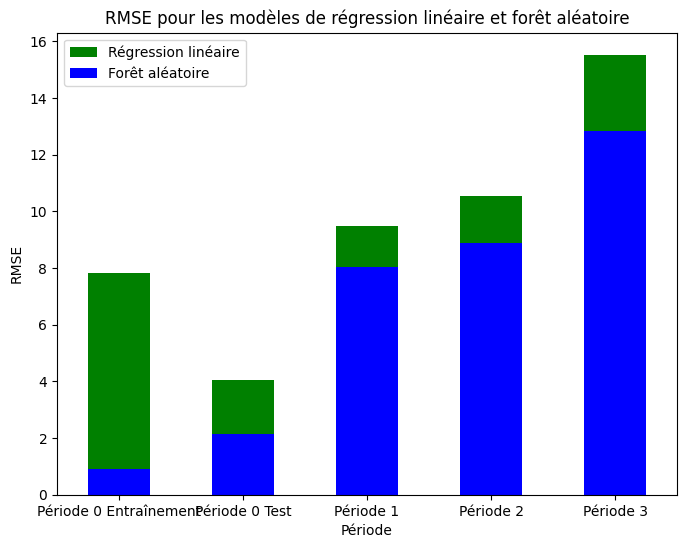

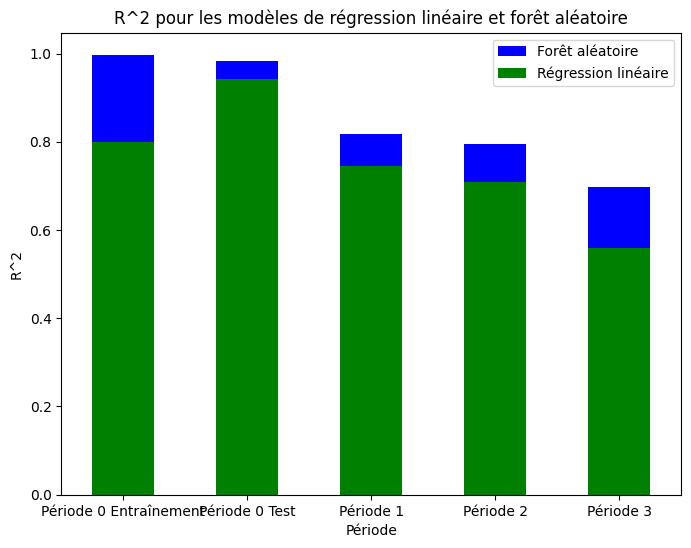

In [171]:
### TRACÉ ###
# Tracé des résultats pour la régression linéaire et forêt aléatoire
# Tracé du RMSE
plt.figure(figsize=(8, 6))
df_errors_lineaire['RMSE'].plot(kind='bar', rot=0, color='green', label='Régression linéaire')
df_errors_foret['RMSE'].plot(kind='bar', rot=0, color='blue', label='Forêt aléatoire')
plt.xlabel('Période')
plt.ylabel('RMSE')
plt.title('RMSE pour les modèles de régression linéaire et forêt aléatoire')
plt.legend()
plt.show()

# Tracé du R^2
plt.figure(figsize=(8, 6))
df_errors_foret['R^2'].plot(kind='bar', rot=0, color='blue', label='Forêt aléatoire')
df_errors_lineaire['R^2'].plot(kind='bar', rot=0, color='green', label='Régression linéaire')
plt.xlabel('Période')
plt.ylabel('R^2')
plt.title('R^2 pour les modèles de régression linéaire et forêt aléatoire')
plt.legend()
plt.show()


# **ANALYSE DES RÉSULTATS**

Dans cette analyse, nous évaluons les performances de deux modèles : la régression linéaire et la forêt aléatoire, en utilisant les mesures RMSE (Root Mean Squared Error) et R^2 (coefficient de détermination). 

Le RMSE mesure l'écart moyen entre les valeurs prédites et les valeurs réelles de la variable "TotalCart". Un RMSE plus faible indique une meilleure précision du modèle, car cela signifie que la distance entre les prédictions et les valeurs réelles est plus petite.

Le coefficient de détermination R^2 quant à lui, varie de 0 à 1 et mesure l'ajustement global du modèle aux données réelles. Un résultat proche de 1 indique une meilleure adéquation du modèle aux données réelles, car il mesure la proportion de la variance de la variable cible qui est expliquée par les variables indépendantes. 

Maintenant, examinons les résultats obtenus pour chaque modèle :

1. **Régression Linéaire**:
   - Pour la période 1, le modèle de régression linéaire présente un RMSE de 9,48 et un R^2 de 0,74. Ces valeurs indiquent une performance acceptable du modèle pour cette période.
   - Pour la période 2, nous observons une performance légèrement inférieure par rapport à la période 1, mais elle reste relativement proche. Cela signifie que le modèle est toujours capable de fournir des prédictions acceptables pour cette période.
   - Cependant, pour la période 3, nous constatons une baisse significative de la performance du modèle, avec un RMSE de 15,53 et un R^2 de 0,56. Cela suggère que les prédictions du modèle ne sont plus fiables pour cette période.

2. **Forêt Aléatoire**:
   - Le modèle de la forêt aléatoire présente un comportement similaire à celui de la régression linéaire, avec des résultats assez proches entre les périodes 1 et 2 et une baisse de la performance pour la periode 3.
   - Cependant, il est important de noter que le modèle de la forêt aléatoire surpasse celui de la régression linéaire en termes de performances. Même pour la période 3, où la performance globale diminue, le modèle de la forêt aléatoire reste plus fiable avec un R^2 de 0,7, ce qui indique une adéquation raisonnable du modèle aux données réelles.

En conclusion, nous constatons que la forêt aléatoire présente des performances généralement supérieures à celles de la régression linéaire. Cependant, il est important de noter que les performances des deux modèles diminuent pour la période 3, ce qui suggère que la prédiction devient moins fiable à mesure que nous nous éloignons des données d'entraînement initiales.

# Mesure de la dérive de variables catégorielles.

Pour deux distributions de probabilités discrètes $P$ et $Q$, la **divergence de Kullback–Leibler** de $P$ par rapport à $Q$ est définie par:

$$D_\text{KL}(P \parallel Q) = \sum_{x\in\mathcal{X}} P(x) \log\left(\frac{P(x)}{Q(x)}\right)$$


On définit la **divergence de Jensen-Shannon** comme une version lisse et symétrique de la divergence de Kullback-Leiber donnée par la formule suivante:

$${\rm JSD}(P \parallel Q)= \frac{1}{2}D(P \parallel M)+\frac{1}{2}D(Q \parallel M)$$

où $M=\frac{1}{2}(P+Q)$

### Exemple de calcul de $D_\text{KL}(P \parallel Q)$ : 

Soient $P$ =`[0.2, 0.3, 0.5]` et $Q$ =`[0.2, 0.4, 0.4]` deux vecteurs définissant une loi de probabilité discrete. Alors : 

$$
\begin{equation}
\begin{split}
D_\text{KL}(P \parallel Q) & = P(0) \log\left(\frac{P(0)}{Q(0)}\right)
                             + P(1) \log\left(\frac{P(1)}{Q(1)}\right)
                             + P(2) \log\left(\frac{P(2)}{Q(2)}\right)\\ \\
                           & = 0.2 \log\left(\frac{0.2}{0.2}\right)
                             + 0.3 \log\left(\frac{0.3}{0.4}\right)
                             + 0.5 \log\left(\frac{0.5}{0.4}\right) \\ \\
                           & = 0.02526...
\end{split}
\end{equation}
$$

### Exercice

* Implémenter des fonctions nommées **`KLDivergence(P, Q)`** et **`JSDivergence(P, Q)`** permettant de calculer les métriques définies ci-dessus.

**Conseils**:
* Utiliser la librairie Numpy permettant de facilement effectuer des calculs d'algèbre linéaire.

In [172]:
import numpy as np 

P = np.array([0.2, 0.3, 0.5])
Q = np.array([0.2, 0.4, 0.4])

def KLDivergence(P, Q):
    # Vérification des dimensions
    assert P.shape == Q.shape, "Les vecteurs de probabilités doivent avoir la même taille."
    
    # Vérification des valeurs des vecteurs
    assert np.all(P >= 0), "Toutes les valeurs de P doivent être positives ou nulles."
    assert np.all(Q >= 0), "Toutes les valeurs de Q doivent être positives ou nulles."
    
    # Normalisation des vecteurs pour s'assurer que leur somme est égale à 1
    P /= np.sum(P)
    Q /= np.sum(Q)
    
    return np.sum(P*np.log(P/Q))

def JSDivergence(P, Q):
    # Vérification des dimensions
    assert P.shape == Q.shape, "Les vecteurs de probabilités doivent avoir la même taille."
    
    # Vérification des valeurs des vecteurs
    assert np.all(P >= 0), "Toutes les valeurs de P doivent être positives ou nulles."
    assert np.all(Q >= 0), "Toutes les valeurs de Q doivent être positives ou nulles."
    
    # Normalisation des vecteurs pour s'assurer que leur somme est égale à 1
    P /= np.sum(P)
    Q /= np.sum(Q)
    
    M = 0.5*(P+Q)
    
    return 0.5 * (KLDivergence(P, M) + KLDivergence(Q, M))


* Lancer la cellule suivante pour tester votre fonction.

In [173]:
print("K-L Divergence:", KLDivergence(P, Q))
print("J-S Divergence:", JSDivergence(P, Q))

K-L Divergence: 0.02526715392157057
J-S Divergence: 0.006367198333995731


# Mesure de la dérive de variables quantitatives.

Soit $P$ une mesure empirique d'échantillons $X_1, \ldots, X_n
$ et $Q$ une mesure empirique d'échantillons $Y_1, \ldots, Y_n$, on définit la **Distance de Wasserstein** d'ordre $p$ par la fonction suivante :

$$W_p(P, Q) = \left( \frac{1}{n}\sum_{i=1}^n \|X_{(i)} - Y_{(i)}\|^p \right)^{1/p}$$

où $X_{(1)}, \ldots, X_{(n)}$ et $Y_{(1)}, \ldots, Y_{(n)}$ sont les [**statistiques d'ordre**](https://en.wikipedia.org/wiki/Order_statistic#Notation_and_examples) des échantillons $X$ et $Y$ et $p$ un nombre entier positif.

### Exercice

* Implémenter une fonction nommée **`WassersteinDistance(X, Y, p)`** permettant de calculer cette métrique à l'ordre **`p`** à partir de **deux échantillons** **`X`** et **`Y`** que l'on supposera de même longueur.

**Conseils**:
* Vous pouvez trier les échantillons pour obtenir les statistiques d'ordre.

In [174]:
def WassersteinDistance(X, Y, p):

    X_sorted = np.sort(X)
    Y_sorted = np.sort(Y)
    n = len(X)

    return np.power(np.sum(np.power(np.abs(X_sorted - Y_sorted), p)) / n, 1/p)
    
    

* Lancer la cellule suivante pour tester votre fonction.

In [175]:
X_WD = np.random.beta(2, 6, 100)

Y_WD = np.random.beta(3, 6, 100)

WassersteinDistance(X_WD, Y_WD, 2)

0.06330673947920444

# Étude de la dérive du modèle.

* En vous appuyant sur les métriques définies précédemment, illustrez et analysez visuellement la **dérive des données** ainsi que **la dérive du modèle** sur les périodes **1 à 3**. 


* Commenter les visualisations et déterminer si le modèle doit être mis à jour ou si sa performance est toujours acceptable. 

**Conseils**:
* Vous serez évalué sur **la rigueur et le soin** que vous donnerez à votre analyse, et sur **vos capacités à synthéthiser votre étude**. Vous ne serez pas évalué sur vos conclusions.


* Vous pouvez normaliser les données par rapport aux **moyennes et variances que vous calculerez sur la période 0** pour que les distances de Wasserstein pour différentes variables soient facilement comparables.

In [176]:
# J'ai opté pour deux approches distinctes pour traiter les variables catégorielles.
# Dans la première approche, j'ai considéré la variable catégorielle "TopCategory" comme une variable quantitative en utilisant la méthode one-hot encoding,
#  puis j'ai appliqué directement la Distance de Wasserstein pour mesurer les différences entre les distributions.

# Dans la deuxième approche, j'ai choisi de ne pas utiliser la méthode one-hot encoding pour la variable "TopCategory".
# À la place, j'ai utilisé les mesures de divergence de Jensen-Shannon et de Kullback-Leibler pour évaluer les différences
#  entre les distributions de cette variable catégorielle.

In [181]:
##### Premier Approche #####
# Analyse avec encodage one-hot de la variable catégorielle "TopCategory"
# On utilise le codage one-hot pour transformer la variable catégorielle "TopCategory" en variables quantitatives

# Variables Quantitatives

# Variables Quantitatives

quantitative_variables = columns

wasserstein_distance = []
variable_wasserstein_distance = []

X_list = [X_test, X1, X2, X3]

for variable in quantitative_variables:
  X_var = X_train[variable]
  mean_period_0 = np.mean(X_var)
  std_period_0 = np.std(X_var)

  for i in range(len(X_list)):
    X_period_i = X_list[i]
    if i == 0:
      Y = X_period_i[variable]
      X_var = X_var[:len(Y)]
    else:
      Y = X_period_i[variable][:len(X_var)]

    if std_period_0 != 0:
      wasserstein_distance.append(abs(((WassersteinDistance(X_var, Y, 1) - mean_period_0 )/ std_period_0)))
    else:
      wasserstein_distance.append(abs(WassersteinDistance(X_var, Y, 1)))

  variable_wasserstein_distance.append(wasserstein_distance)
  wasserstein_distance = []






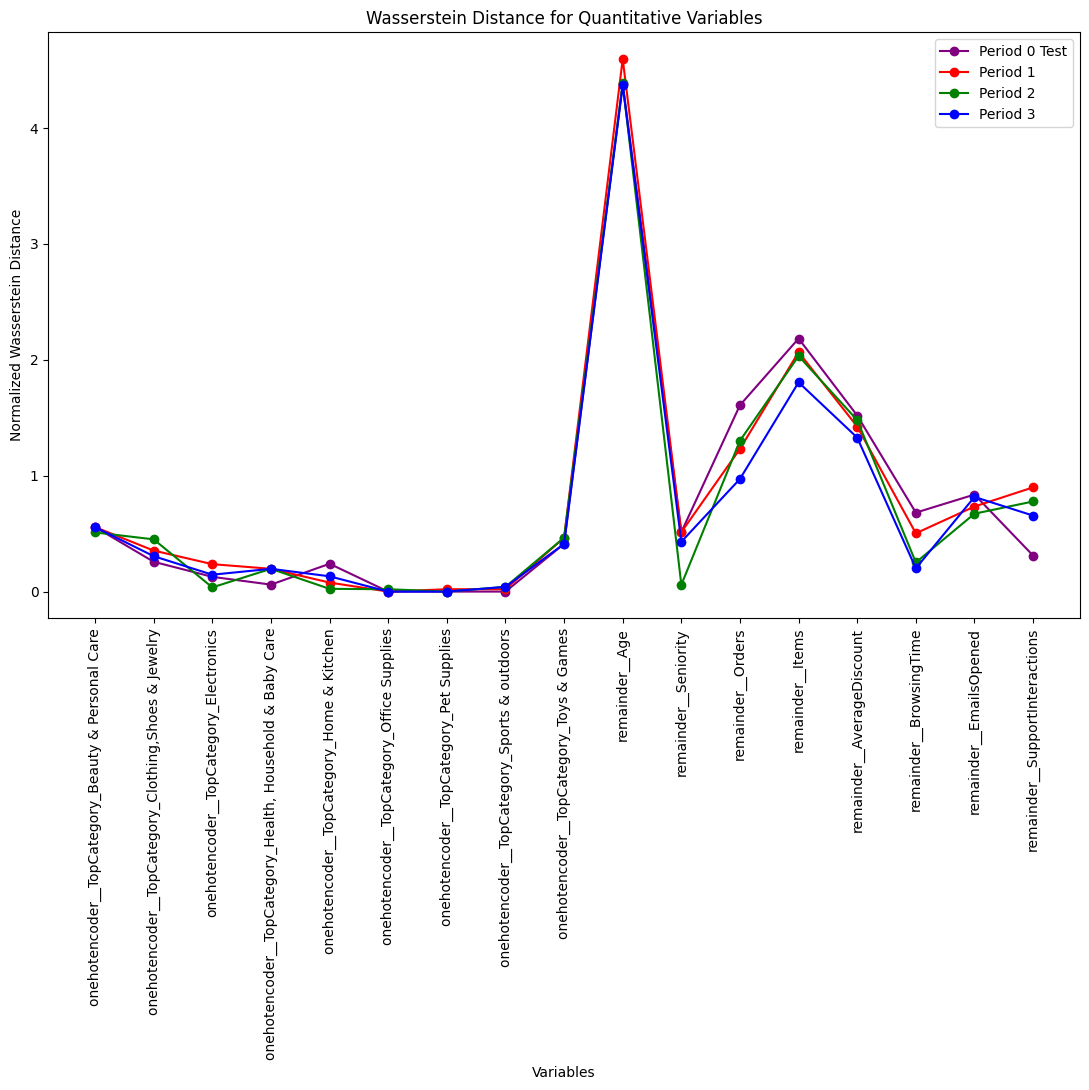

In [182]:
# Plotting the Wasserstein distances

plt.figure(figsize=(11, 11), dpi=100)
plt.xlabel('Variables')
plt.ylabel('Normalized Wasserstein Distance')
plt.title('Wasserstein Distance for Quantitative Variables')
plt.plot([i for i in range(len(columns))], [x[0] for x in variable_wasserstein_distance], marker='o', color = 'purple', label='Period 0 Test')
plt.plot([i for i in range(len(columns))], [x[1] for x in variable_wasserstein_distance], marker='o', color = 'red', label='Period 1')
plt.plot([i for i in range(len(columns))], [x[2] for x in variable_wasserstein_distance], marker='o', color = 'green', label='Period 2')
plt.plot([i for i in range(len(columns))], [x[3] for x in variable_wasserstein_distance], marker='o', color = 'blue', label='Period 3')
plt.xticks([i for i in range(len(columns))], columns, rotation='vertical')
plt.legend()
plt.tight_layout()
plt.show()



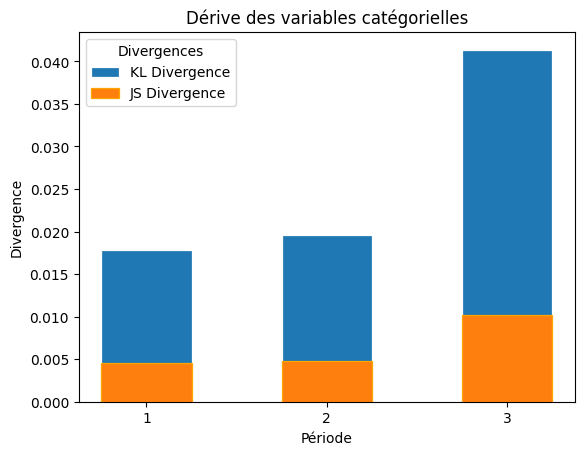

In [178]:
# Analyse sans encodage one-hot de la variable catégorielle "TopCategory"
# On ne fait pas de transformation de la variable catégorielle "TopCategory" et on la considère comme une variable catégorielle

period_list = [df_period_1, df_period_2, df_period_3]
categorical_vars = ["TopCategory"]

divergences_kl = []
divergences_js = []


for i in range(len(period_list)):

  df_period_i = period_list[i]

  kl_divergence = KLDivergence(df_period_0[categorical_vars].value_counts(normalize=True),
                                 df_period_i[categorical_vars].value_counts(normalize=True))
  js_divergence = JSDivergence(df_period_0[categorical_vars].value_counts(normalize=True),
                                df_period_i[categorical_vars].value_counts(normalize=True))
  divergences_kl.append(kl_divergence)
  divergences_js.append(js_divergence)

# Visualisation de la dérive des variables catégorielles
fig, ax = plt.subplots()
x = ['1', '2', '3']
ax.bar(x, divergences_kl, width=0.5, edgecolor="white", linewidth=0.9, label = 'KL Divergence')
ax.bar(x, divergences_js, width=0.5, edgecolor="orange", linewidth=0.9, label = 'JS Divergence')
ax.legend(title='Divergences')

plt.xlabel('Période')
plt.ylabel('Divergence')
plt.title('Dérive des variables catégorielles')
plt.show()




  


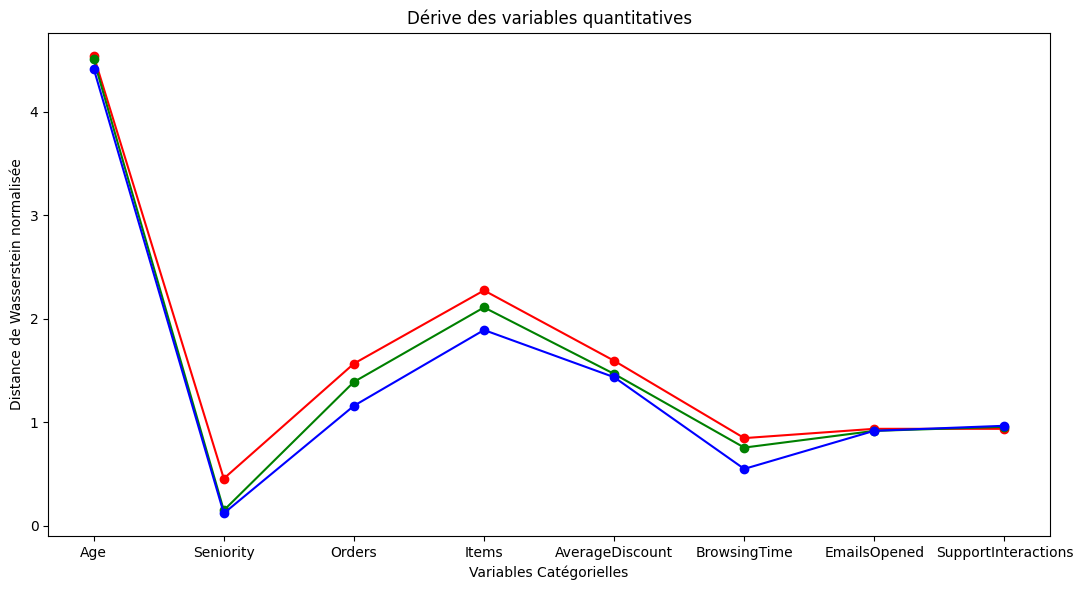

In [179]:
# Variables Quantitatives

quantitative_variables = ['Age', 'Seniority', 'Orders', 'Items', 'AverageDiscount',
                          'BrowsingTime', 'EmailsOpened', 'SupportInteractions']

wasserstein_distance = []
variable_wasserstein_distance = []

for variable in quantitative_variables:
  X_var = df_period_0[variable]
  mean_period_0 = np.mean(X_var)
  std_period_0 = np.std(X_var)

  for i in range(len(period_list)):
    df_period_i = period_list[i]
    Y = df_period_i[variable]
    wasserstein_distance.append(abs(((WassersteinDistance(X_var, Y, 1) - mean_period_0 )/ std_period_0)))

  variable_wasserstein_distance.append(wasserstein_distance)
  wasserstein_distance = []




# Visualisation de la dérive des variables quantitatives
#plt.subplot(122)
plt.figure(figsize=(11, 6), dpi=100)
plt.plot(quantitative_variables, [x[0] for x in variable_wasserstein_distance], marker='o', color = 'red')
plt.plot(quantitative_variables, [x[1] for x in variable_wasserstein_distance], marker='o', color = 'green')
plt.plot(quantitative_variables, [x[2] for x in variable_wasserstein_distance], marker='o', color = 'blue')
plt.xlabel('Variables Catégorielles')
plt.ylabel('Distance de Wasserstein normalisée')
plt.title('Dérive des variables quantitatives')
#plt.xticks(x_periods)

plt.tight_layout()
plt.show()

# **ANALYSE**

De manière générale, on peut dire que plus les valeurs des divergences et de la distance de Wasserstein se rapprochent de zéro, plus les variables du période en question sont similaires à celles du période 0.

# **Variables Catégoriques**

En regardant le graphique "derivée des variables catégorielles", on peut constater que la distance des données de la variable "TopCategories" pour les périodes 1, 2 et 3 ne diffère pas beaucoup de celle du période 0. Comparativement entre les périodes 1, 2 et 3, on peut observer que les valeurs entre les périodes 1 et 2 sont très proches, tandis que celle du période 3 est plus éloignée.

En analysant les variables catégoriques considérées comme quantitatives après la transformation par le one-hot-encoder, on remarque que, dans leur majorité, les valeurs des catégories pour les périodes 1, 2 et 3 sont très proches de celles du période 0. Seules les variables *'onehotencoder__TopCategory_Beauty & Personal Care',* *'onehotencoder__TopCategory_Clothing,Shoes & Jewelry',* *'onehotencoder__TopCategory_Electronics',* *'onehotencoder__TopCategory_Health, Household & Baby Care'* sont un peu plus éloignées, mais comparées à d'autres variables quantitatives, elles restent plus proches des valeurs du période 0.

# **Variables Quantitatives**

Nous commencerons par analyser les périodes, puis nous passerons à une analyse des variables.

En ce qui concerne les périodes, les valeurs de la distance de Wasserstein pour les périodes 1 et 2 ne diffèrent pas beaucoup, tandis que pour le période 3, on observe une distance plus significative. Cela signifie que les données du période 3, en général, pour la plupart des variables, présentent un modèle différent de celui du période 0. Cela concorde avec l'analyse des métriques RMSE et R^2 que nous avons effectuée sur les modèles, où nous avons constaté une diminution significative des performances des modèles pour le période 3. Étant donné que les données entre le période 0 et le période 3 ont un comportement/modèle différent, il est logique que le modèle ait de moins bonnes performances pour le période 3.

En ce qui concerne les variables, nous pouvons clairement constater que les variables "Age" et "Items" ont une distance de Wasserstein beaucoup plus élevée que les autres variables pour n'importe quel période considéré. Cela signifie que ce sont des variables dont le comportement est très volatile d'un période à l'autre et qui ne sont peut-être pas pertinentes à inclure dans l'entraînement du modèle.

**Conclusions:**

En analysant les résultats, nous pouvons tirer les conclusions suivantes :

1. Les variables catégoriques, en particulier lorsqu'elles sont transformées en variables quantitatives à l'aide du one-hot-encoder, montrent une similarité élevée avec le période 0, à l'exception de quelques catégories spécifiques.

2. Les variables quantitatives présentent des différences plus marquées entre les périodes, en particulier pour les

 variables "Age" et "Items", qui montrent une grande volatilité et un comportement distinct entre les périodes.

3. La performance des modèles est significativement réduite pour le période 3, ce qui est cohérent avec les différences observées dans les métriques de distance de Wasserstein et la conclusion que le comportement des données diffère entre le période 0 et le période 3.

4. En tenant compte de ces conclusions, il serait recommandé de prendre en considération les variables catégoriques, en particulier celles qui montrent une plus grande différence, ainsi que d'évaluer attentivement l'inclusion des variables "Age" et "Items" dans le modèle, en raison de leur comportement volatile et de leur impact potentiel sur les performances globales.




################### RÉGRESSION LINÉAIRE ################### 

                             RMSE       R^2
Période                                    
Période 0 Entraînement   8.373991  0.771556
Période 0 Test           4.893328  0.913964
Période 1                9.754357  0.730592
Période 2               10.753775  0.697889
Période 3               15.241026  0.575243 

################### FORÊT ALÉATOIRE ################### 

                             RMSE       R^2
Période                                    
Période 0 Entraînement   1.640896  0.991228
Période 0 Test           3.896359  0.945451
Période 1                8.349817  0.802591
Période 2                8.789069  0.798196
Période 3               12.381722  0.719667


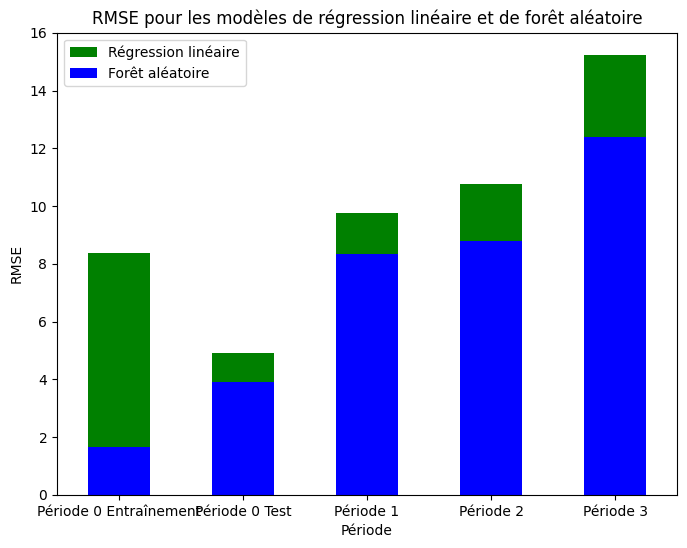

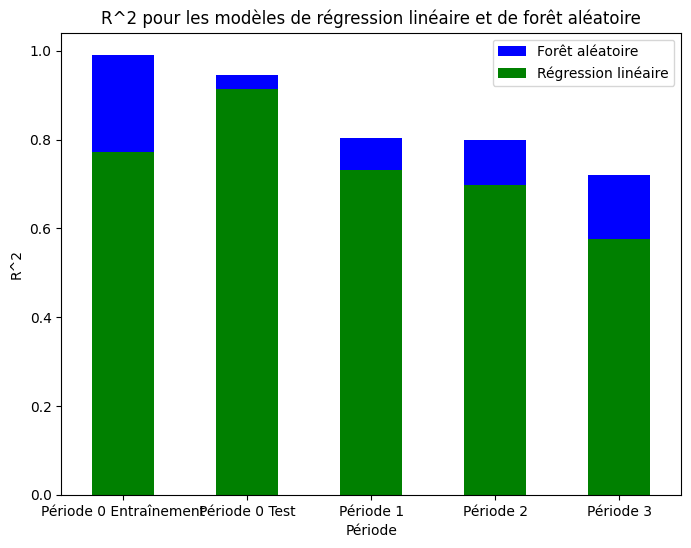

In [185]:
### Modèles entrainés sans les variables "Age" et "Items"

categorical_column = ['TopCategory']

one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_column),
    remainder='passthrough')

# Period 0
X = df_period_0.drop(["TotalCart", "Age", "Items"], axis=1)
y = df_period_0["TotalCart"]
X = one_hot_enc.fit_transform(X)
columns = one_hot_enc.get_feature_names_out()

# Detection of outliers with IQR on the data of Period 0
outlier_mask = detect_outliers_IQR(X, columns)
X = X[outlier_mask]
y = y[outlier_mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

# Hyperparameter tuning for Linear Regression
param_grid = {'fit_intercept': [True, False]}
model = LinearRegression()
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# Period 1
X1 = df_period_1.drop(["TotalCart", "Age", "Items"], axis=1)
y1 = df_period_1["TotalCart"]
X1 = one_hot_enc.transform(X1)
X1 = pd.DataFrame(X1, columns=columns)

# Period 2
X2 = df_period_2.drop(["TotalCart", "Age", "Items"], axis=1)
y2 = df_period_2["TotalCart"]
X2 = one_hot_enc.transform(X2)
X2 = pd.DataFrame(X2, columns=columns)

# Period 3
X3 = df_period_3.drop(["TotalCart", "Age", "Items"], axis=1)
y3 = df_period_3["TotalCart"]
X3 = one_hot_enc.transform(X3)
X3 = pd.DataFrame(X3, columns=columns)

# Entraînement des modèles
########## RÉGRESSION LINÉAIRE ##########

model_lineaire = LinearRegression()
model_lineaire.fit(X_train, y_train)


########## FORÊT ALÉATOIRE ##########

model_foret = RandomForestRegressor()
model_foret.fit(X_train, y_train)

# Test et Évaluation des Modèles

id_list = ['Période 0 Entraînement', 'Période 0 Test', 'Période 1', 'Période 2', 'Période 3'] 
X_list = [X_train, X_test, X1, X2, X3]
y_list = [y_train, y_test, y1, y2, y3]

########## RÉGRESSION LINÉAIRE ##########
RMSE_lineaire = []
R2_lineaire = [] 

def regression_lineaire(X, y):
  # Prédiction du modèle
  predictions = model_lineaire.predict(X)

  # Calcul du RMSE
  rmse = mean_squared_error(y, predictions, squared=False)

  # Calcul du R^2
  r2 = r2_score(y, predictions)

  # Ajout des résultats pour le tracé
  RMSE_lineaire.append(rmse)
  R2_lineaire.append(r2)


########## FORÊT ALÉATOIRE ##########
RMSE_foret = []
R2_foret = [] 

def foret_aleatoire(X, y):
    # Prédiction du modèle
    predictions = model_foret.predict(X)

    # Calcul du RMSE
    rmse = mean_squared_error(y, predictions, squared=False)

    # Calcul du R^2
    r2 = r2_score(y, predictions)

    # Ajout des résultats à la liste
    RMSE_foret.append(rmse)
    R2_foret.append(r2)

##################################
for i in range(len(X_list)):
  regression_lineaire(X_list[i], y_list[i])
  foret_aleatoire(X_list[i], y_list[i])


# Définition d'un dictionnaire contenant le RMSE et le R^2 pour chaque jeu de données et pour chaque modèle
# RÉGRESSION LINÉAIRE
data_lineaire = {'RMSE': RMSE_lineaire,
    'R^2': R2_lineaire,
    'Période': id_list}

# FORÊT ALÉATOIRE
data_foret = {'RMSE': RMSE_foret,
    'R^2': R2_foret,
    'Période': id_list}
  
# Conversion du dictionnaire en DataFrame
# RÉGRESSION LINÉAIRE
df_errors_lineaire = pd.DataFrame(data_lineaire)
df_errors_lineaire.set_index('Période', inplace=True)
print("################### RÉGRESSION LINÉAIRE ################### \n")
print(df_errors_lineaire, '\n')

# FORÊT ALÉATOIRE
df_errors_foret = pd.DataFrame(data_foret)
df_errors_foret.set_index('Période', inplace=True)
print("################### FORÊT ALÉATOIRE ################### \n")
print(df_errors_foret)

### TRACÉ ###
# Tracé des résultats pour la régression linéaire et la forêt aléatoire
# Tracé du RMSE
plt.figure(figsize=(8, 6))
df_errors_lineaire['RMSE'].plot(kind='bar', rot=0, color='green', label='Régression linéaire')
df_errors_foret['RMSE'].plot(kind='bar', rot=0, color='blue', label='Forêt aléatoire')
plt.xlabel('Période')
plt.ylabel('RMSE')
plt.title('RMSE pour les modèles de régression linéaire et de forêt aléatoire')
plt.legend()
plt.show()

# Tracé du R^2
plt.figure(figsize=(8, 6))
df_errors_foret['R^2'].plot(kind='bar', rot=0, color='blue', label='Forêt aléatoire')
df_errors_lineaire['R^2'].plot(kind='bar', rot=0, color='green', label='Régression linéaire')
plt.xlabel('Période')
plt.ylabel('R^2')
plt.title('R^2 pour les modèles de régression linéaire et de forêt aléatoire')
plt.legend()
plt.show()
